# Prepare Shape data

## Data
All data is in the **data** directory with 1 directory per user.
### Shapes
- Ellipse
- Rectangle
- Triangle
- Other

## Separation between Train, Validation and Test sets
Each user will have all their images in 1 of the 3 sets. 


---
## ETL - Processing
For each of the Train, Validation and Test set:
- Load the image files
  - 70px x 70px gray (black on white) png files
- Normalize image:
  - All gray pixel are represented as a value between 0 and 1.
  - Black on white images are transformed to **white on black**.
- Prepare the labels based on the directory name  
- Load **Train**, **Validation** and **Test** data into pickles for Classification

---
Francois Robert

In [1]:
import imageio
import numpy as np
import os
from pathlib import Path
from six.moves import cPickle as pickle
import ntpath

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

seed1 = 125
np.random.seed(seed1)

In [2]:
from platform import python_version
print(python_version())

3.11.12


In [3]:
BASEDIR = ".."

DATA_DIR        = os.path.join(BASEDIR, "..", "..", "data")

PICKLE_DIR     = os.path.join(BASEDIR, "pickles")
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, 'train.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, 'val.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, 'test.pickle')

BASEDIR

'..'

In [4]:
# Define the Users for the validation set and the test set
# The Rest will go in the Training set
#
# The following definitions are arbitrary, but this is balanced and works well.
validation_users = ['crt', 'il1', 'lts', 'mrt', 'nae']
test_users =  ['u01', 'u17', 'u18', 'u19']

In [5]:
# Set image properties
image_size  = 70 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [6]:
# Create Pickle directory
Path(PICKLE_DIR).mkdir(parents=True, exist_ok=True)

In [7]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

# Functions

In [8]:
def get_label_for_shape(shape_dir):
    shape = os.path.basename(shape_dir)
    if shape == "other":
        return 0
    elif shape == "ellipse":
        return 1
    elif shape == "rectangle":
        return 2
    elif shape == "triangle":
        return 3
    else:
        raise Exception('Unknown shape: %s' % shape)

In [9]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]

def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [10]:
# Normalize image by pixel depth by making it white on black instead of black on white
def normalize_image(image_file, pixel_depth):
    try:
        array = imageio.imread(image_file)
    except ValueError:
        raise

    return 1.0 - (array.astype(float))/pixel_depth  # (1 - x) will make it white on black

In [11]:
def save_to_pickle(pickle_file, object, force=True):
    """
    Save an object to a pickle file
    """       
    if os.path.exists(pickle_file) and not force:
        print(f'{pickle_file} already present, skipping pickling')
    else:
        try:
            with open(pickle_file, 'wb') as file:
                pickle.dump(object, file, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print(f'Unable to save object to {pickle_file}: {e}')
            raise

In [12]:
def load_images_for_shape(shape_directory, pixel_depth, user_images,
                          user_images_label, label, verbose=False, min_nimages=1):
    """
    Load all images for a specific user and shape
    """      

    if verbose:
        print("directory for load_images_for_shapes: ", shape_directory)

    image_files = get_file_paths(shape_directory)
    image_index = 0

    for image_file in image_files:
        try:
            if path_leaf(image_file).startswith('.'):  # skip files like .DSStore
                continue

            image_data_all_channels = normalize_image(image_file, pixel_depth)
            image_data = image_data_all_channels[:, :, 0]

            user_images.append(image_data)
            user_images_label.append(label)
            image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image_file)

    if image_index < min_nimages:
        raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nimages))

In [13]:
def load_images_for_user(user_directory, pixel_depth,
                         user_images, user_images_label,
                         verbose=False):
    """
    Load all images for a specific user
    """      
    
    images_dir = os.path.join(user_directory, "images")

    if verbose:
        print("directory for load_images_for_shapes: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        label = get_label_for_shape(dir)
        if label >= 0:
            load_images_for_shape(dir, pixel_depth, user_images, user_images_label, label)

In [14]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [15]:
def display_images(X, Y):
    """ 
    This function shows images with their real labels
    Presentation is rows of 10 images
    """

    fig = plt.figure(figsize=(13, 10))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.7)
    nb_pictures = len(X)
    nb_per_row = 10
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row, nb_per_row, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

In [16]:
# Get directory and file paths of Shape data
data_paths = get_dir_paths(DATA_DIR)
print(f"Dataset contains 1 directory per user:")
data_paths

Dataset contains 1 directory per user:


['../../../data/user.aly',
 '../../../data/user.crt',
 '../../../data/user.drt',
 '../../../data/user.elu',
 '../../../data/user.frt',
 '../../../data/user.if1',
 '../../../data/user.if2',
 '../../../data/user.if3',
 '../../../data/user.if5',
 '../../../data/user.if8',
 '../../../data/user.il1',
 '../../../data/user.ilb',
 '../../../data/user.im1',
 '../../../data/user.lrt',
 '../../../data/user.lt1',
 '../../../data/user.lts',
 '../../../data/user.mrt',
 '../../../data/user.nae',
 '../../../data/user.nld',
 '../../../data/user.u01',
 '../../../data/user.u02',
 '../../../data/user.u03',
 '../../../data/user.u04',
 '../../../data/user.u05',
 '../../../data/user.u06',
 '../../../data/user.u07',
 '../../../data/user.u08',
 '../../../data/user.u09',
 '../../../data/user.u10',
 '../../../data/user.u11',
 '../../../data/user.u12',
 '../../../data/user.u13',
 '../../../data/user.u14',
 '../../../data/user.u17',
 '../../../data/user.u18',
 '../../../data/user.u19',
 '../../../data/user.vly']

# Training data

In [17]:
train_user_images = []
train_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id not in validation_users and user_id not in test_users:
        load_images_for_user(user_dir, pixel_depth, train_user_images, train_user_images_label)

train_data = np.array(train_user_images)
train_labels = np.array(train_user_images_label)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

unique, counts = np.unique(train_labels, return_counts=True)
print("train label dist.: ", dict(zip(unique, counts)))

# Save train data to single pickle file
save_to_pickle(
    TRAIN_DATAFILE,
    {
        'train_data': train_data,
        'train_labels': train_labels
    }
)

print('Train Set Pickle saved in: ', TRAIN_DATAFILE)

/var/folders/1f/q9g5tr213c30q60j421ywm7c0000gn/T/ipykernel_46180/2512793696.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  array = imageio.imread(image_file)


train_data shape:  (21386, 70, 70)
train_labels shape:  (21386,)
train label dist.:  {0: 5316, 1: 5025, 2: 5737, 3: 5308}
Train Set Pickle saved in:  ../pickles/train.pickle


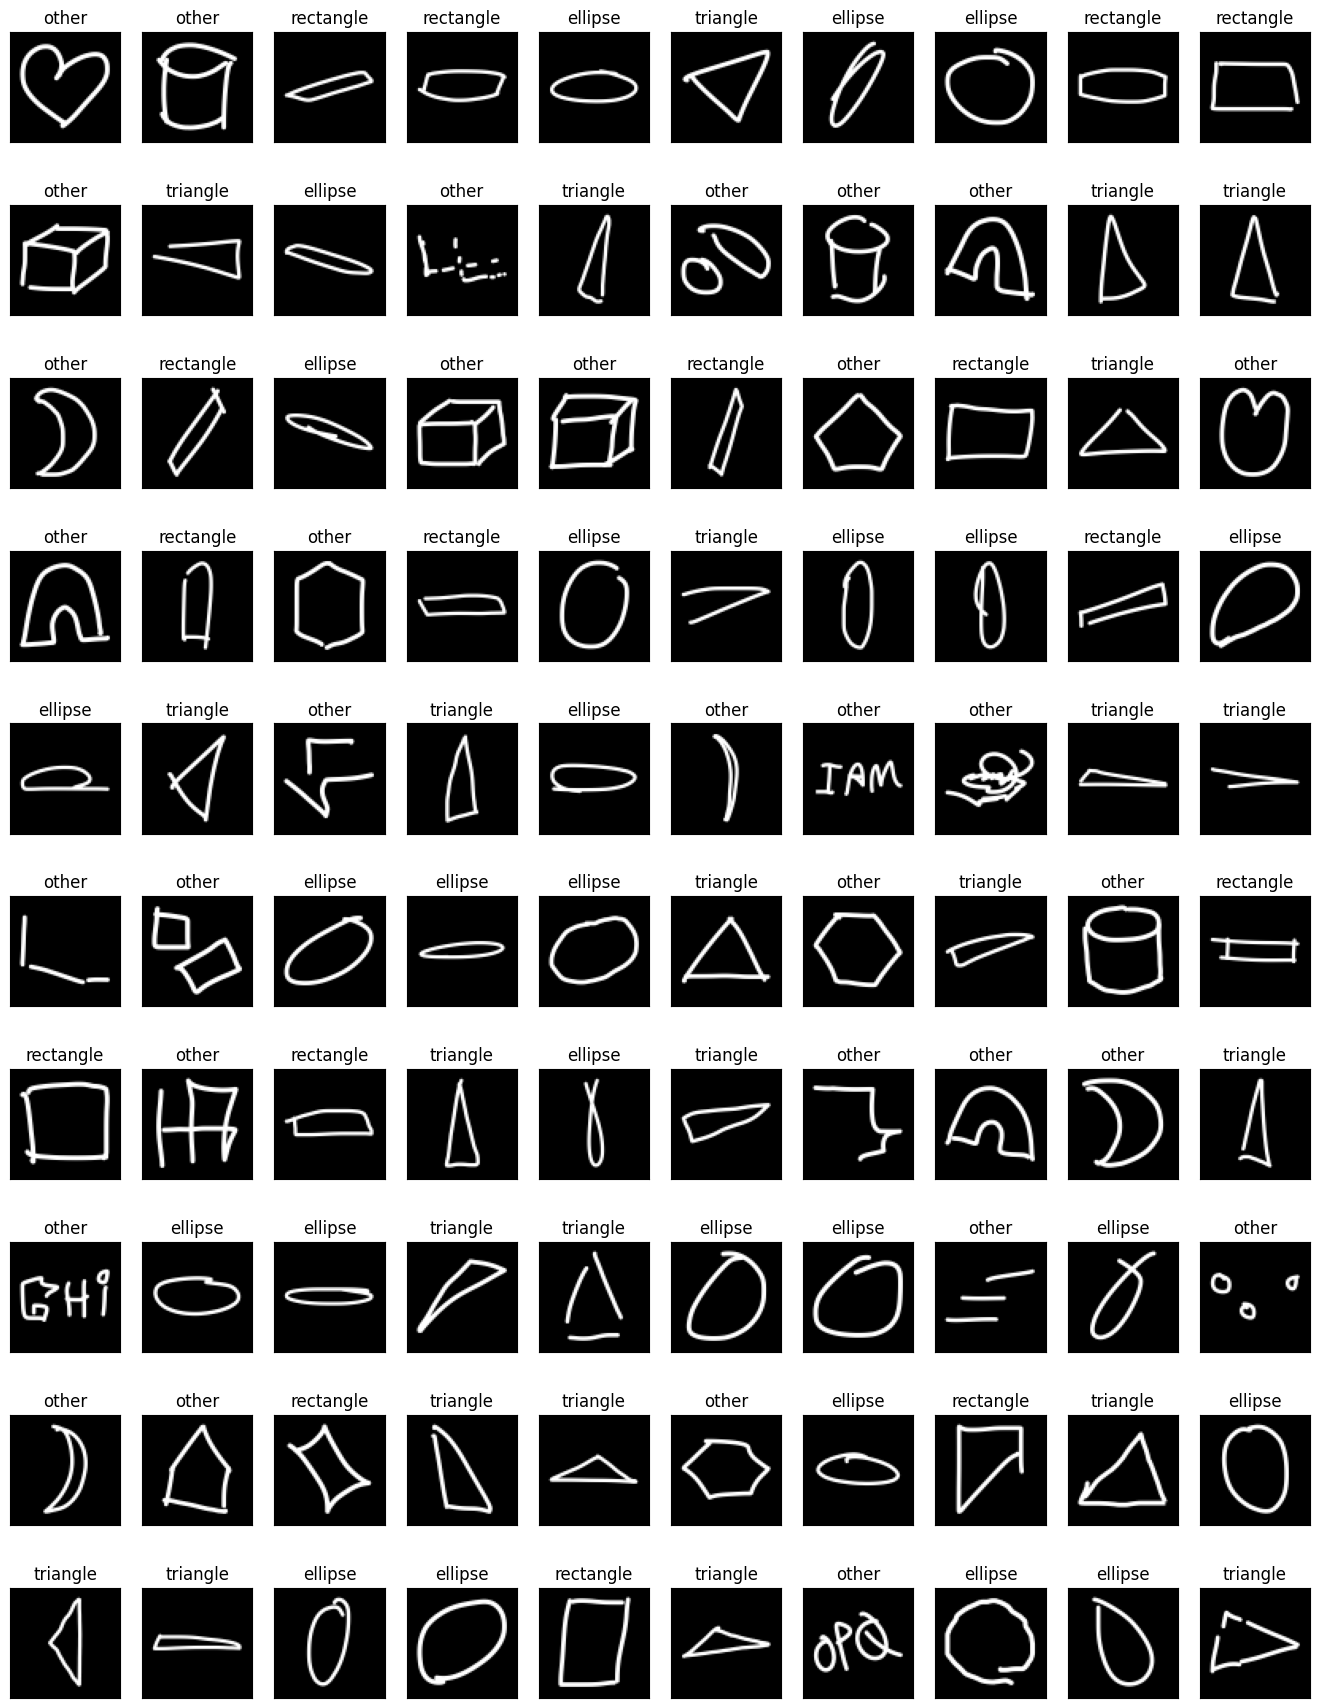

In [18]:
# Show random images from the Train Set
indexes = np.arange(len(train_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images(train_data[first_random_indexes],train_labels[first_random_indexes])

In [19]:
del train_data
del train_labels

# Validation data

In [20]:
val_user_images = []
val_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in validation_users:    
        load_images_for_user(user_dir, pixel_depth, val_user_images, val_user_images_label)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
unique, counts = np.unique(val_labels, return_counts=True)
print("val label dist.: ", dict(zip(unique, counts)))

# Save validation data to single pickle file
save_to_pickle(
    VAL_DATAFILE,
    {
        'val_data': val_data,
        'val_labels': val_labels
    }
)
print('Validation Set Pickle saved in: ', VAL_DATAFILE)

/var/folders/1f/q9g5tr213c30q60j421ywm7c0000gn/T/ipykernel_46180/2512793696.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  array = imageio.imread(image_file)


val_data shape:  (3983, 70, 70)
val_labels shape:  (3983,)
val label dist.:  {0: 1130, 1: 1069, 2: 860, 3: 924}
Validation Set Pickle saved in:  ../pickles/val.pickle


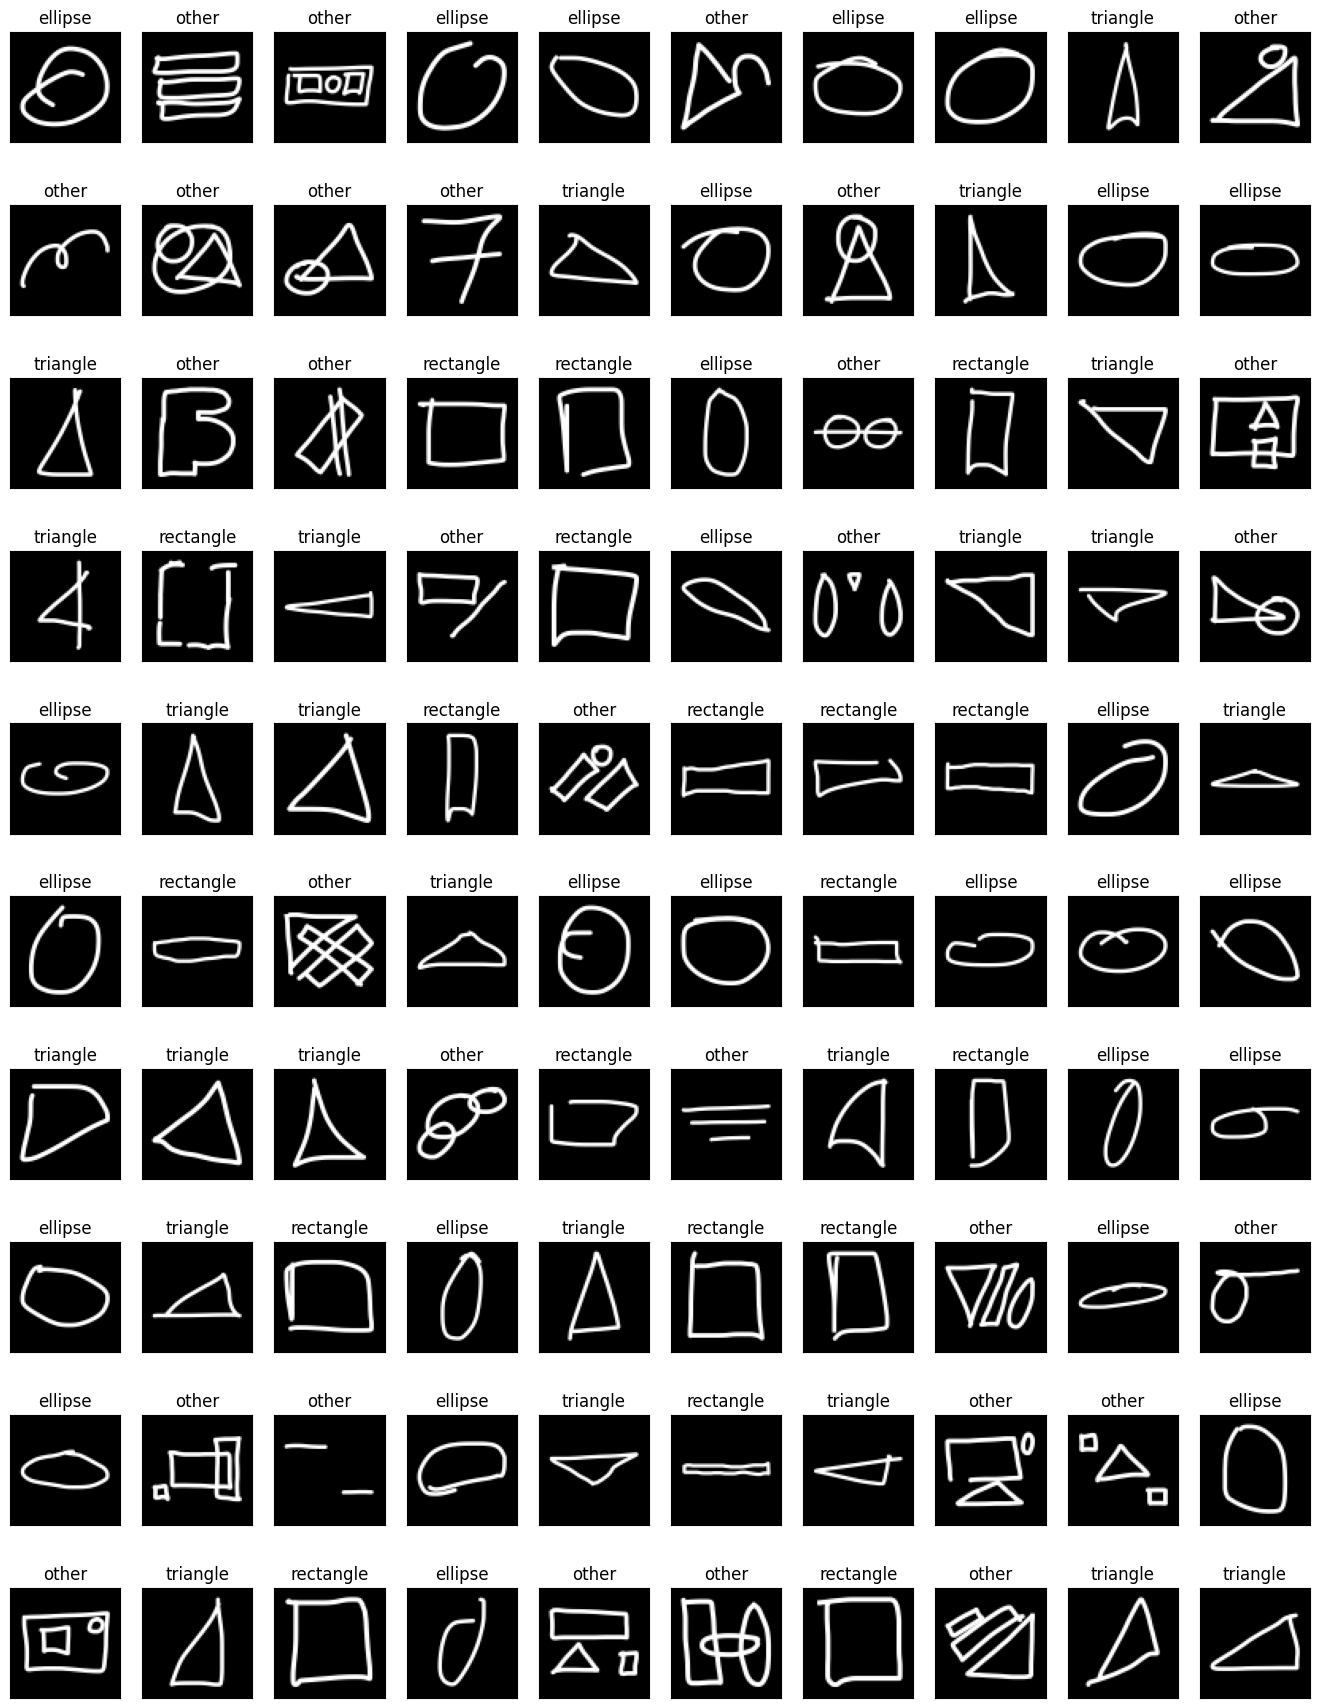

In [21]:
# Show random images from the Validation Set
indexes = np.arange(len(val_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images(val_data[first_random_indexes],val_labels[first_random_indexes])

In [22]:
del val_data
del val_labels

# Test data

In [23]:
test_user_images = []
test_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:] # User unique id is the last 3 letters
    if user_id in test_users:  
        load_images_for_user(user_dir, pixel_depth, test_user_images, test_user_images_label)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)
unique, counts = np.unique(test_labels, return_counts=True)
print("test label dist.: ", dict(zip(unique, counts)))

# Save Test data to single pickle file
save_to_pickle(
    TEST_DATAFILE,
    {
        'test_data': test_data,
        'test_labels': test_labels
    }
)
print('Test Set Pickle saved in: ', TEST_DATAFILE)

/var/folders/1f/q9g5tr213c30q60j421ywm7c0000gn/T/ipykernel_46180/2512793696.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  array = imageio.imread(image_file)


test_data shape:  (1923, 70, 70)
test_labels shape:  (1923,)
test label dist.:  {0: 841, 1: 360, 2: 359, 3: 363}
Test Set Pickle saved in:  ../pickles/test.pickle


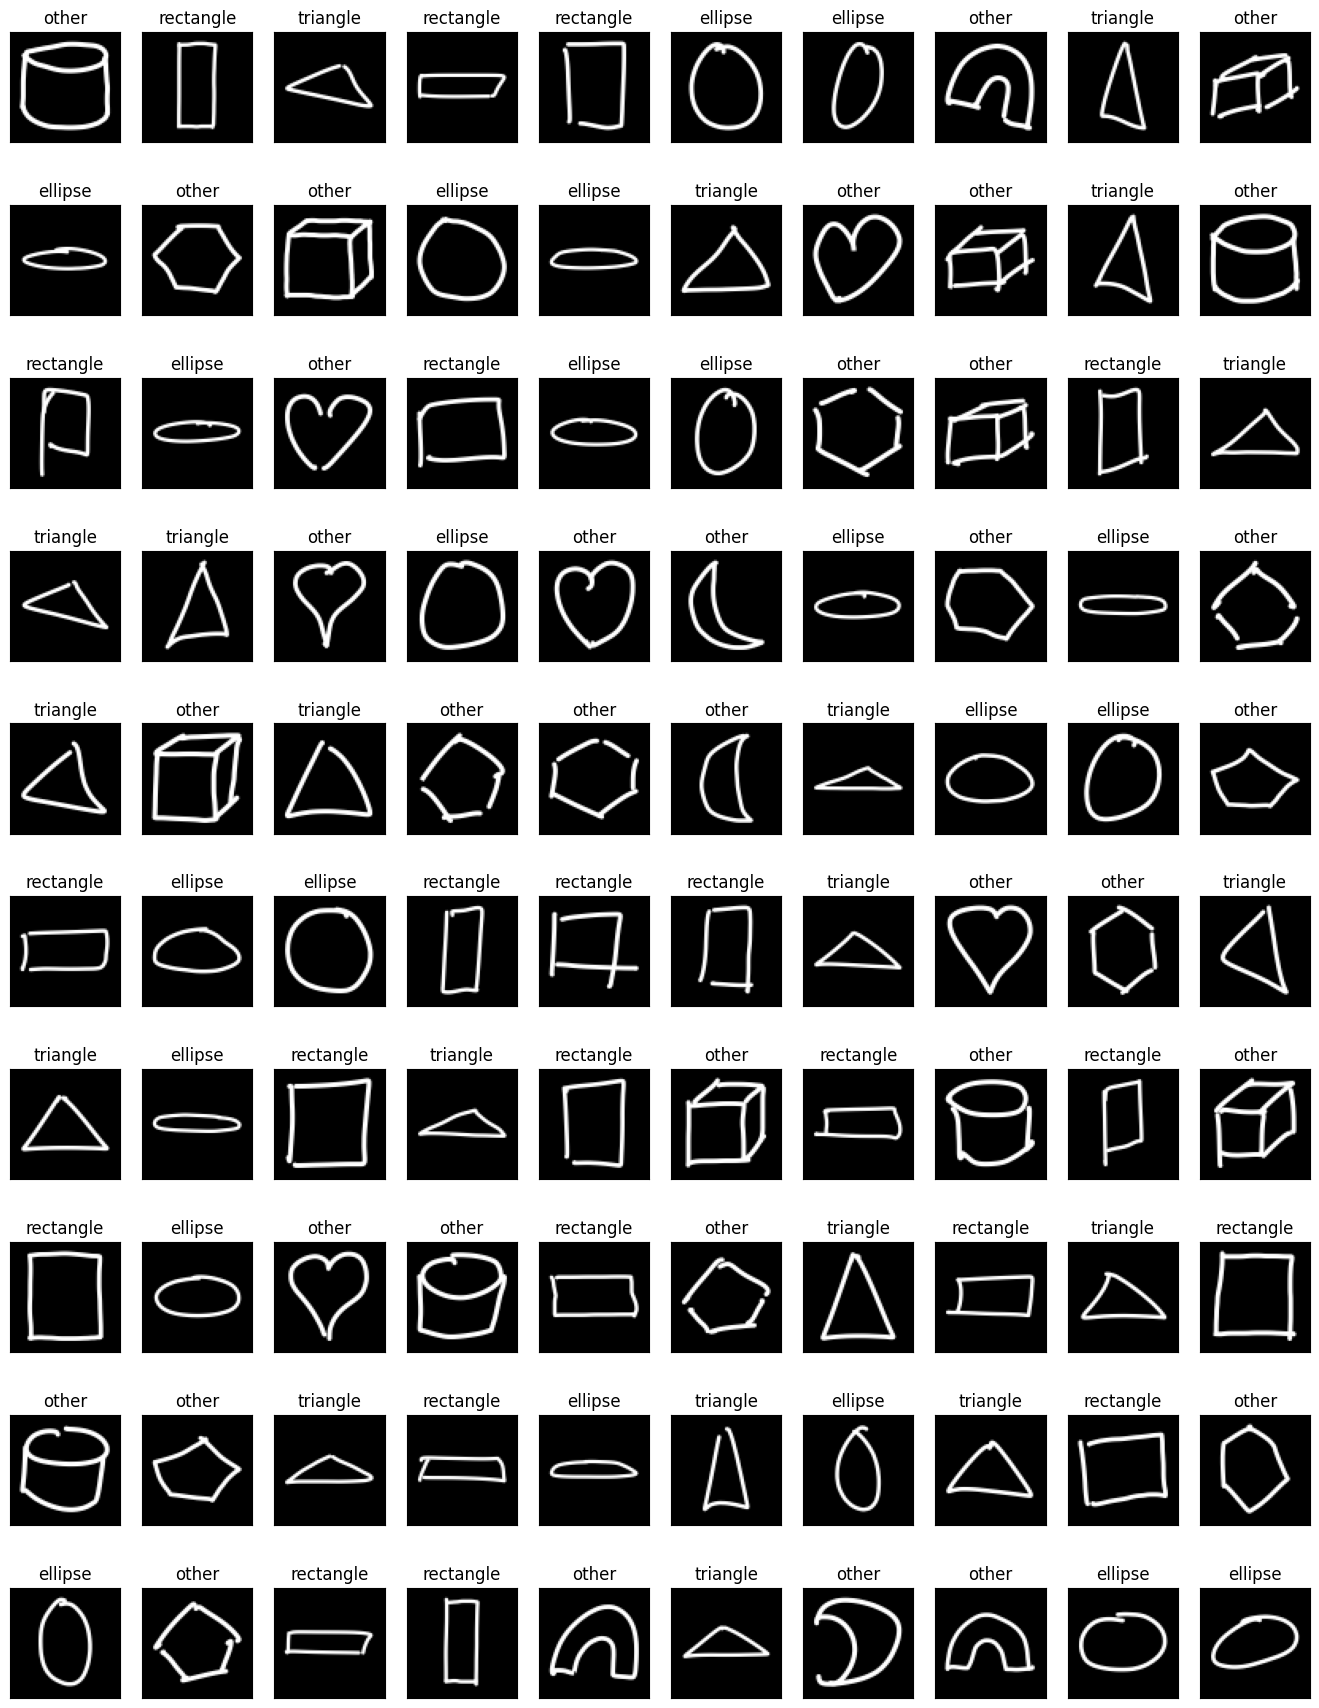

In [24]:
# Show random images from the Test Set
indexes = np.arange(len(test_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images(test_data[first_random_indexes], test_labels[first_random_indexes])

## ETL Completed